In [1]:
import time
import numpy as np
import pandas as pd
import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import gc

from tqdm import tqdm

from scipy.stats import gmean
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_dir = "data/competition_data/"

train = pd.read_csv(path_dir + "train.csv")
test = pd.read_csv(path_dir + "test.csv")
bki = pd.read_csv(path_dir + "bki.csv")
client_profile = pd.read_csv(path_dir + "client_profile.csv")
payments = pd.read_csv(path_dir + "payments.csv")
history = pd.read_csv(path_dir + "applications_history.csv")
submit = pd.read_csv(path_dir + "sample_submit.csv")

In [3]:
print(f"Train.shape = {train.shape}")
print(f"Test.shape = {test.shape}")
print(f"BKI.shape = {bki.shape}")
print(f"Client_profile.shape = {client_profile.shape}")
print(f"Payments.shape = {payments.shape}")
print(f"Applications_history.shape = {history.shape}")
print(f"Submit.shape = {submit.shape}")

Train.shape = (110093, 3)
Test.shape = (165141, 2)
BKI.shape = (945234, 17)
Client_profile.shape = (250000, 24)
Payments.shape = (1023932, 8)
Applications_history.shape = (1670214, 26)
Submit.shape = (165141, 2)


# Анализ данных

In [4]:
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [5]:
test.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash


In [6]:
bki.head(2)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [7]:
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
payments.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645


In [9]:
history.head(2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [10]:
submit.head(2)

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0


In [11]:
def merge_dfs(df):
    df = df.merge(client_profile, how="left", on="APPLICATION_NUMBER")
    
    df = df.merge(bki, how="left", on="APPLICATION_NUMBER")
    
    df = df.merge(payments, how="left", on="APPLICATION_NUMBER")
    
#     df = df.merge(history.add_suffix("_HIST"), how="left", left_on="APPLICATION_NUMBER", right_on="APPLICATION_NUMBER_HIST")
    
#     df = df.merge(bki.groupby("APPLICATION_NUMBER").count().add_suffix("_COUNT"), 
#                   how="left", 
#                   on="APPLICATION_NUMBER")
    
#     df = df.merge(payments.groupby("APPLICATION_NUMBER").mean().add_suffix("_MEAN"), 
#                   how="left", 
#                   on="APPLICATION_NUMBER")
    
#     df = df.merge(history.groupby("APPLICATION_NUMBER").median().add_suffix("_MEDIAN_HISTORY"), 
#                   how="left", 
#                   on="APPLICATION_NUMBER")
    
    return df

In [12]:
train = merge_dfs(train)
test = merge_dfs(test)

print(f"Train.shape = {train.shape}")
print(f"Test.shape = {test.shape}")

Train.shape = (1086422, 49)
Test.shape = (1630923, 48)


In [13]:
train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,Consumer credit,2162.0,NaN,49796018.0,1.0,4.0,2830.0,2830.0,3289.635,3289.635
1,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,Consumer credit,2162.0,NaN,49796018.0,1.0,7.0,2740.0,2740.0,3289.635,3289.635
2,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,Consumer credit,2162.0,NaN,49713743.0,1.0,5.0,2551.0,2547.0,9262.215,9251.865
3,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,Consumer credit,2162.0,NaN,49713743.0,1.0,7.0,2491.0,2519.0,9262.215,10.350
4,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Consumer credit,731.0,NaN,49672074.0,1.0,9.0,450.0,457.0,11349.900,11349.900


In [14]:
train.columns

Index(['APPLICATION_NUMBER', 'TARGET', 'NAME_CONTRACT_TYPE', 'GENDER',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'BUREAU_ID', 'CREDIT_ACTIVE',
       'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'PREV_APPLICATION_NUMBER',
       'NUM_INSTALME

In [15]:
train.describe()

,APPLICATION_NUMBER,TARGET,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,...,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.086422e+06,1.086422e+06,881728.000000,8.817280e+05,8.817280e+05,881646.000000,881728.000000,881728.000000,881728.000000,300511.000000,...,1.015070e+06,1.015070e+06,2.961960e+05,1.012919e+06,1.012919e+06,1.012919e+06,1.012919e+06,1.012751e+06,1.012919e+06,1.012751e+06
mean,1.235771e+08,8.216973e-02,0.426532,1.677164e+05,5.987212e+05,27112.038315,0.020979,16041.345144,67756.964825,11.937447,...,1.986512e+01,6.134388e+02,1.625299e+04,4.917107e+07,8.432204e-01,1.962177e+01,1.090822e+03,1.099541e+03,1.756388e+04,1.788791e+04
std,8.848571e+04,2.746233e-01,0.729702,9.505571e+04,4.008354e+05,14637.902524,0.013742,4366.797643,139464.285739,12.068352,...,2.490294e+03,7.849071e+02,3.370525e+05,5.370310e+05,1.016212e+00,2.724306e+01,8.057157e+02,8.055564e+02,5.578152e+04,6.034594e+04
min,1.234233e+08,0.000000e+00,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000533,7679.000000,2.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,4.826822e+07,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,1.235013e+08,0.000000e+00,0.000000,1.125000e+05,2.700000e+05,16456.500000,0.010006,12450.000000,930.000000,5.000000,...,0.000000e+00,3.400000e+01,0.000000e+00,4.869842e+07,0.000000e+00,4.000000e+00,3.980000e+02,4.070000e+02,3.927015e+03,3.334590e+03
50%,1.235770e+08,0.000000e+00,0.000000,1.485000e+05,5.196330e+05,24750.000000,0.018850,15756.000000,2226.000000,9.000000,...,0.000000e+00,4.250000e+02,0.000000e+00,4.916724e+07,1.000000e+00,8.000000e+00,8.880000e+02,8.970000e+02,8.505495e+03,7.875000e+03
75%,1.236534e+08,0.000000e+00,1.000000,2.025000e+05,8.086500e+05,34596.000000,0.028663,19688.000000,5781.000000,15.000000,...,0.000000e+00,9.330000e+02,1.364926e+04,4.963691e+07,1.000000e+00,2.100000e+01,1.731000e+03,1.740000e+03,1.643850e+04,1.588378e+04
max,1.237308e+08,1.000000e+00,19.000000,4.500000e+06,4.050000e+06,225000.000000,0.072508,25196.000000,365243.000000,65.000000,...,1.097438e+06,4.193100e+04,5.747623e+07,5.011171e+07,4.300000e+01,2.540000e+02,2.922000e+03,3.054000e+03,2.383749e+06,2.476718e+06


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086422 entries, 0 to 1086421
Data columns (total 49 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   APPLICATION_NUMBER          1086422 non-null  int64  
 1   TARGET                      1086422 non-null  int64  
 2   NAME_CONTRACT_TYPE          1086422 non-null  object 
 3   GENDER                      881728 non-null   object 
 4   CHILDRENS                   881728 non-null   float64
 5   TOTAL_SALARY                881728 non-null   float64
 6   AMOUNT_CREDIT               881728 non-null   float64
 7   AMOUNT_ANNUITY              881646 non-null   float64
 8   EDUCATION_LEVEL             881728 non-null   object 
 9   FAMILY_STATUS               881728 non-null   object 
 10  REGION_POPULATION           881728 non-null   float64
 11  AGE                         881728 non-null   float64
 12  DAYS_ON_LAST_JOB            881728 non-null   float64
 1

In [17]:
for clmn in train.select_dtypes(include=['object']).columns:
    print(train[clmn].value_counts(dropna=False), "\n")

Cash           982290
Credit Card    104132
Name: NAME_CONTRACT_TYPE, dtype: int64 

F      580882
M      300844
NaN    204694
XNA         2
Name: GENDER, dtype: int64 

Secondary / secondary special    623750
Higher education                 217301
NaN                              204694
Incomplete higher                 29599
Lower secondary                   10705
Academic degree                     373
Name: EDUCATION_LEVEL, dtype: int64 

Married                 562331
NaN                     204694
Single / not married    130976
Civil marriage           86800
Separated                57385
Widow                    44208
Unknown                     28
Name: FAMILY_STATUS, dtype: int64 

Closed      642858
Active      368256
NaN          71352
Sold          3953
Bad debt         3
Name: CREDIT_ACTIVE, dtype: int64 

currency 1    1014363
NaN             71352
currency 2        628
currency 3         77
currency 4          2
Name: CREDIT_CURRENCY, dtype: int64 

Consumer credit     

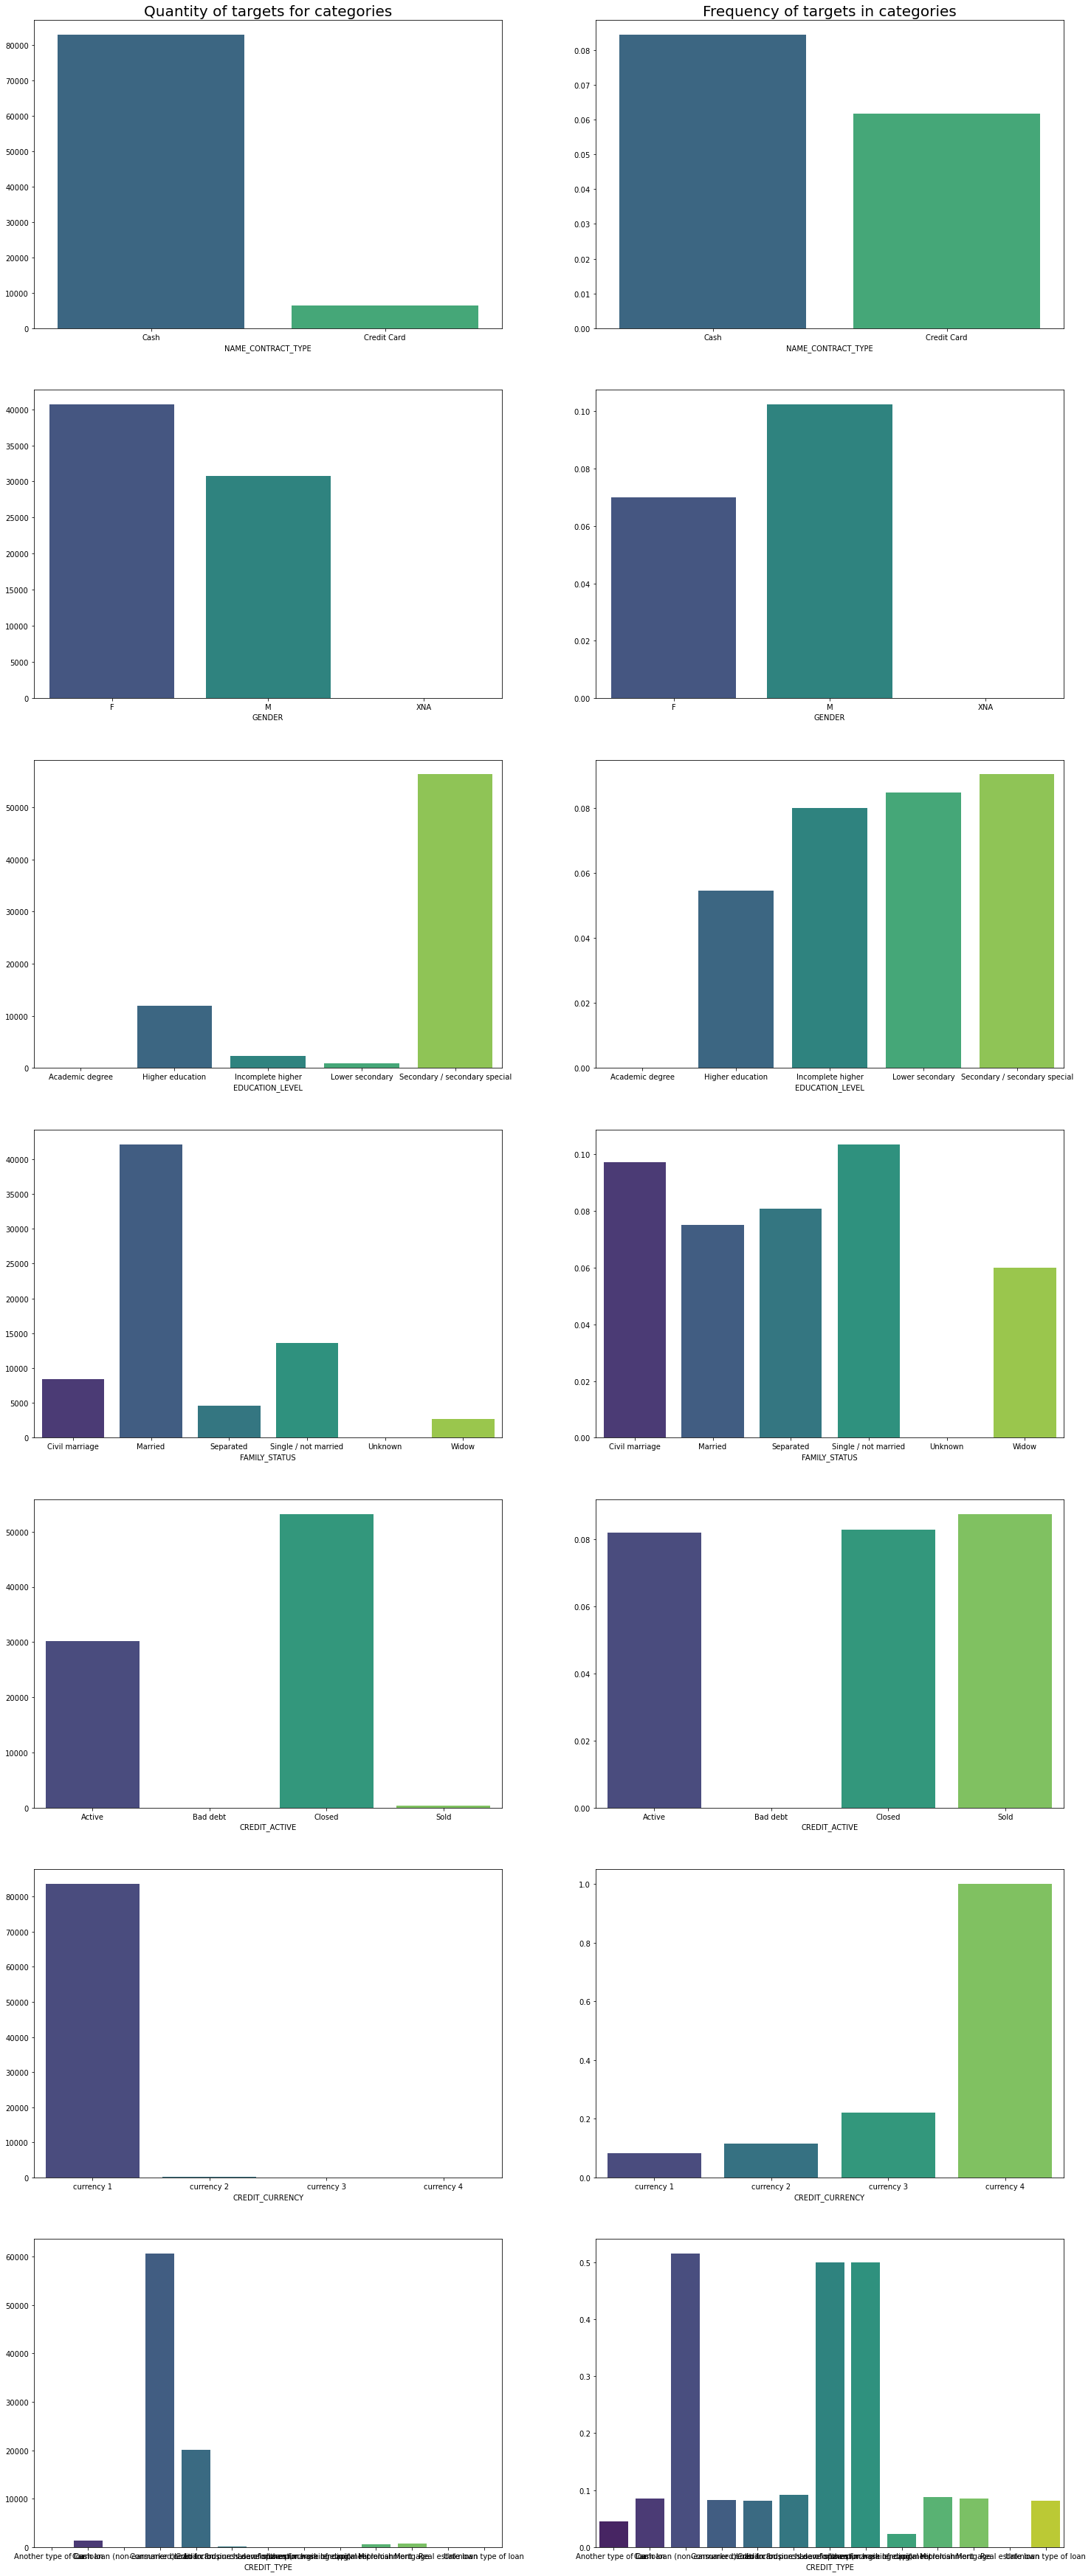

In [18]:
obj_features = train.select_dtypes(include=['object']).columns
fig, axes = plt.subplots(len(obj_features), 2, figsize=(25, len(obj_features)*9))

for num, feature in enumerate(obj_features):
    statistics_count = train.groupby([feature])["TARGET"].sum()
    statistics_freq = train.groupby([feature])["TARGET"].sum() / train.groupby([feature])["TARGET"].count()

    sns.barplot(
        x=statistics_count.index,
        y=statistics_count.values,
        palette="viridis",
        ax=axes[num, 0]
    )
    
    sns.barplot(
        x=statistics_freq.index,
        y=statistics_freq.values,
        palette="viridis",
        ax=axes[num, 1]
    )

axes[0, 0].set_title('Quantity of targets for categories', fontsize=20)
axes[0, 1].set_title('Frequency of targets in categories', fontsize=20);

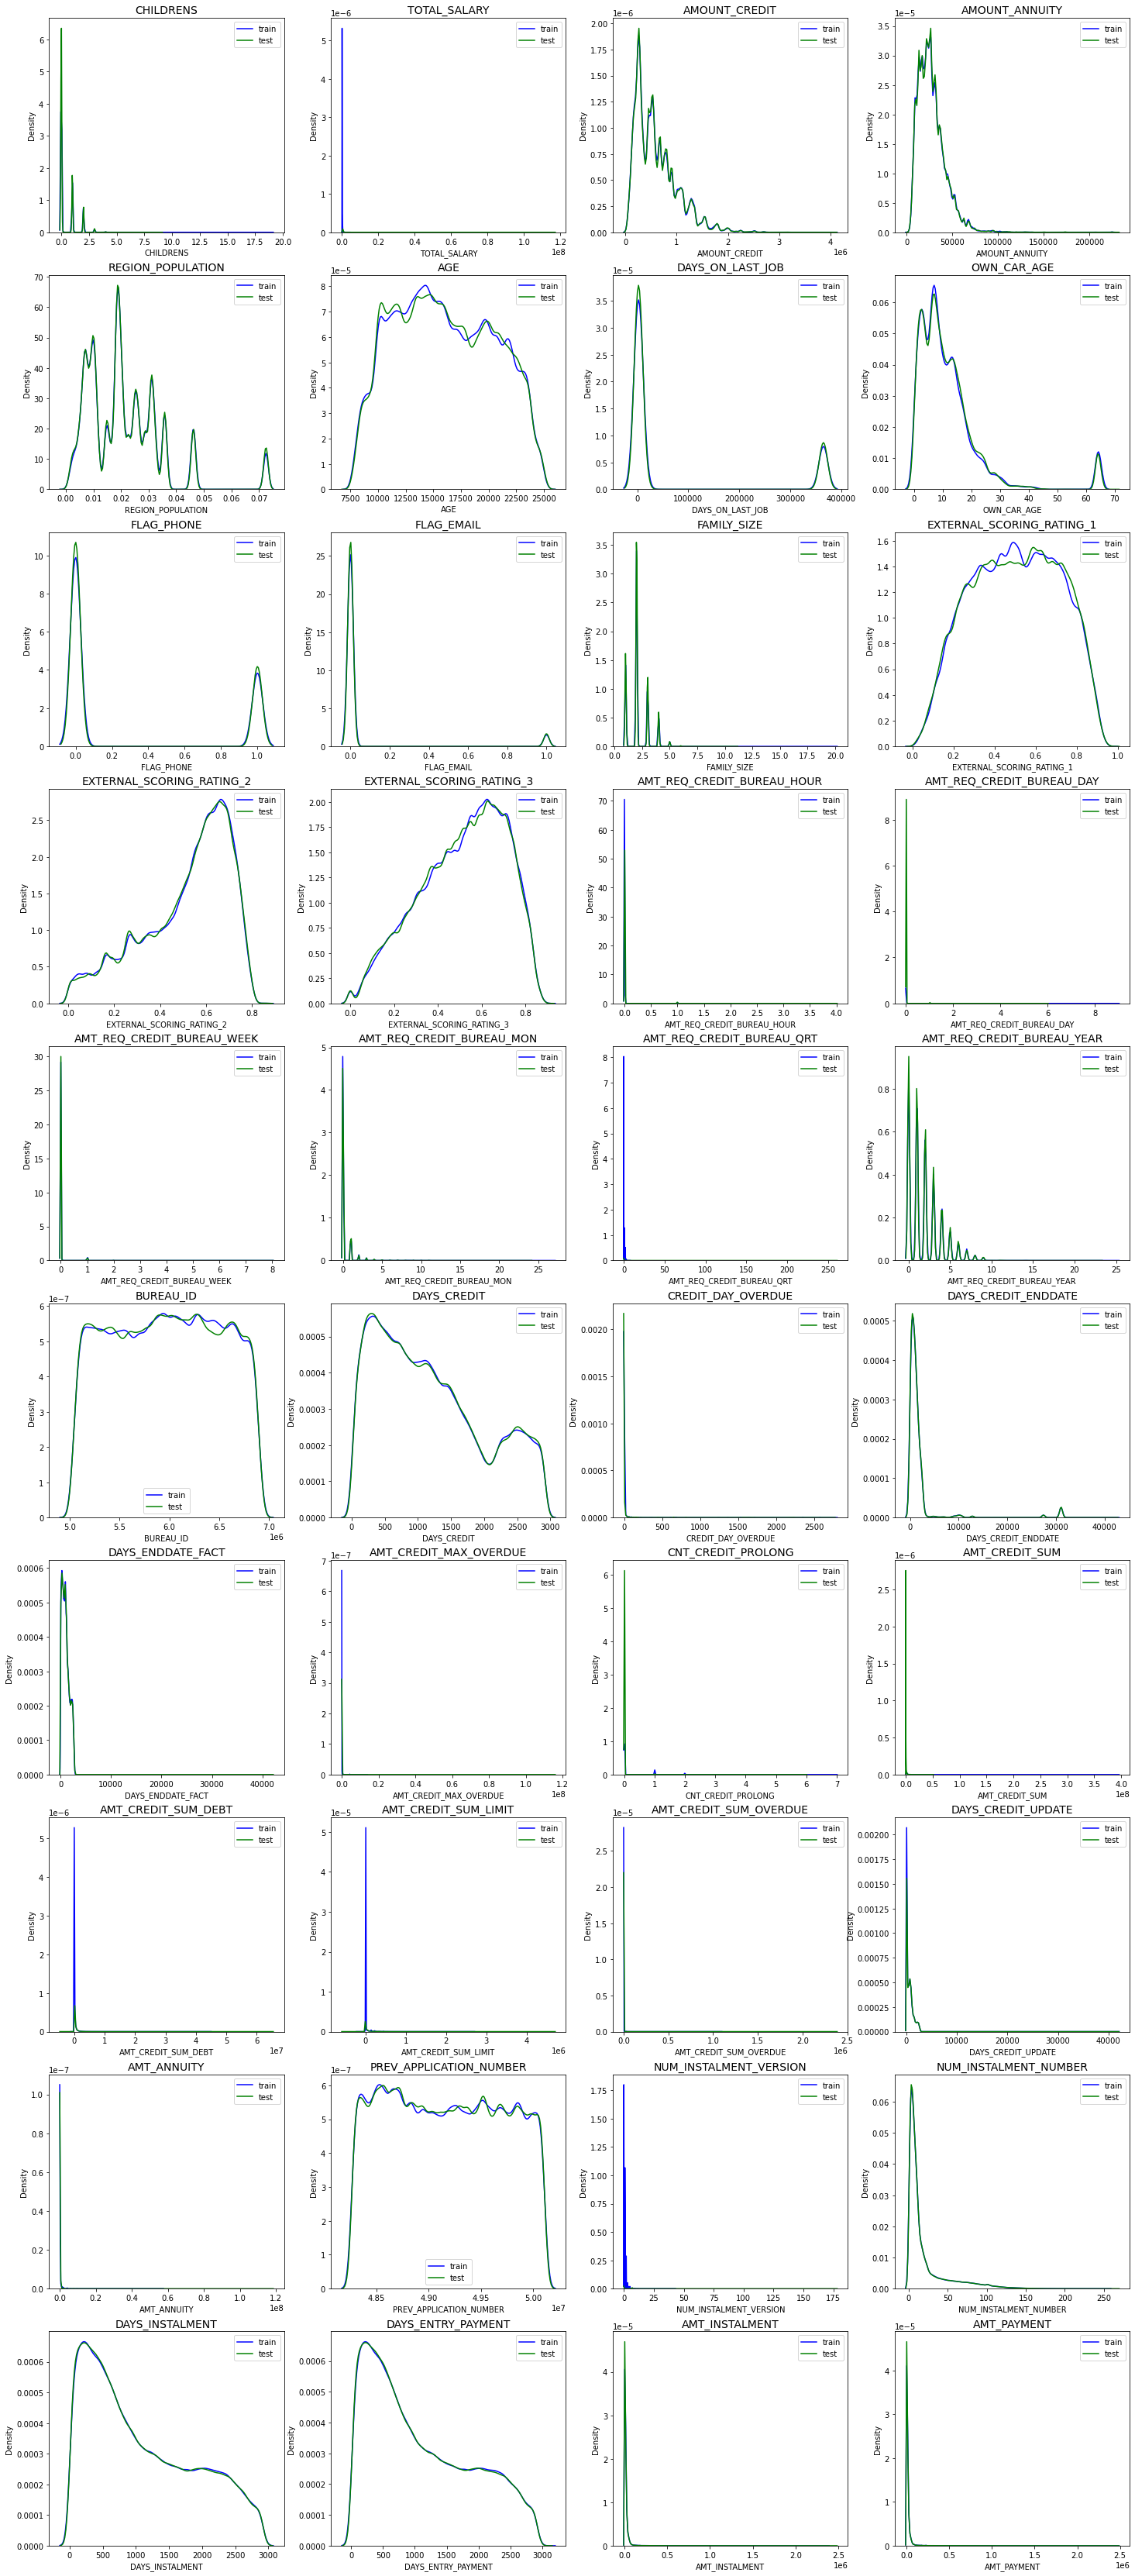

In [19]:
num_features = train.select_dtypes(exclude=['object', 'int64']).columns

fig, axes = plt.subplots(2*len(num_features)//4-int(len(num_features)/4), 4, 
                         figsize=(25, 60))

for num, feature in enumerate(num_features):
    try:
        sns.kdeplot(train[feature], ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test[feature], ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        sns.kdeplot(train[feature], ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)
    axes[num//4, num%4].legend();

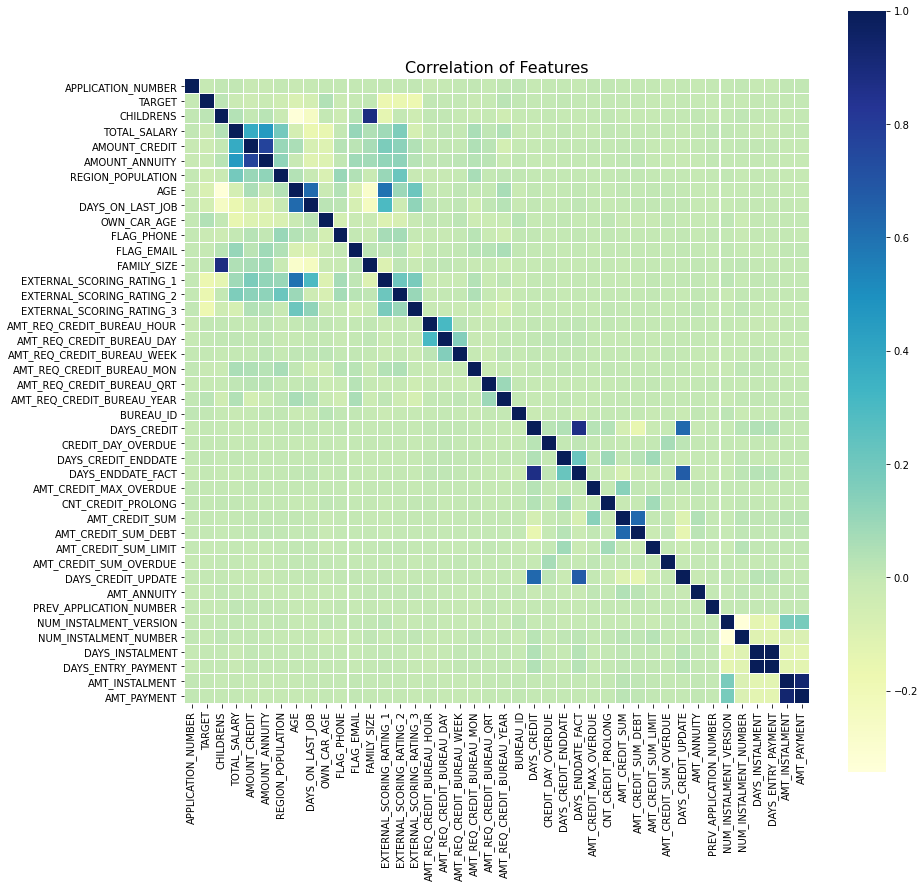

In [20]:
fig, axes = plt.subplots(figsize=(14, 14))
plt.title("Correlation of Features", y=1, size=16)
sns.heatmap(train.corr(), square=True, cmap="YlGnBu", linewidths=.05);

# Анализ пропусков

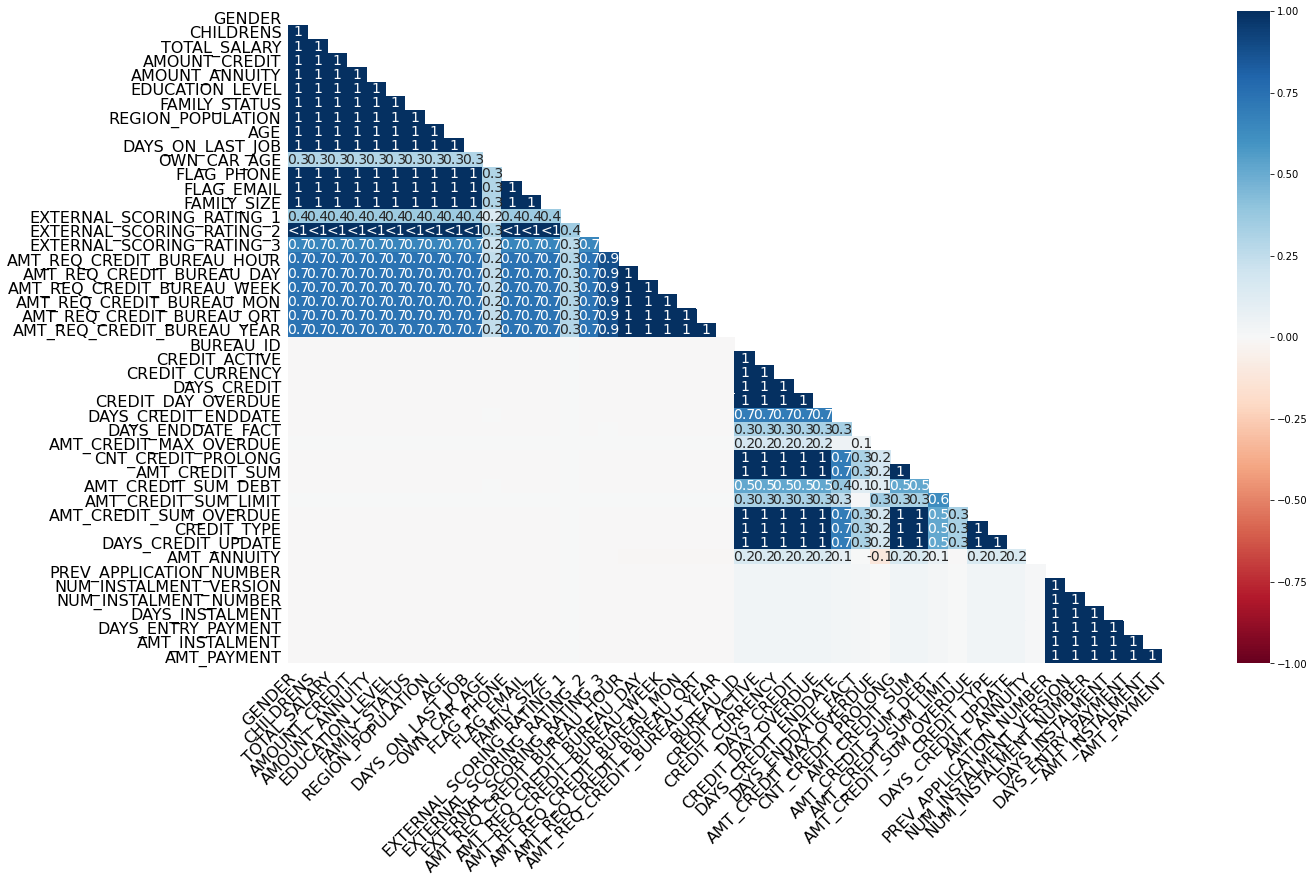

In [21]:
msno.heatmap(train);

Train


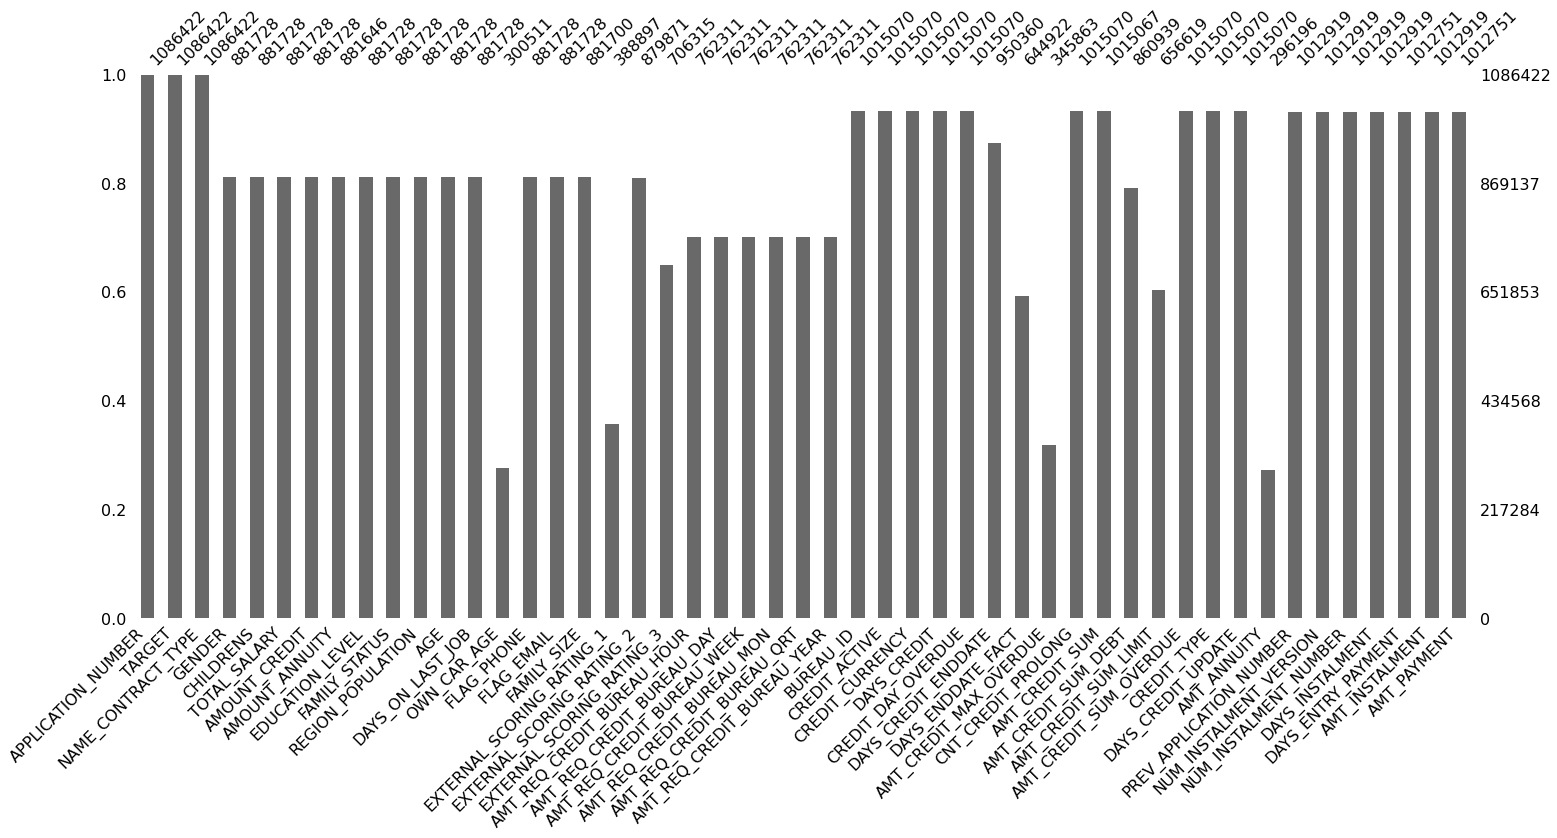

In [22]:
print("Train")
msno.bar(train);

Test


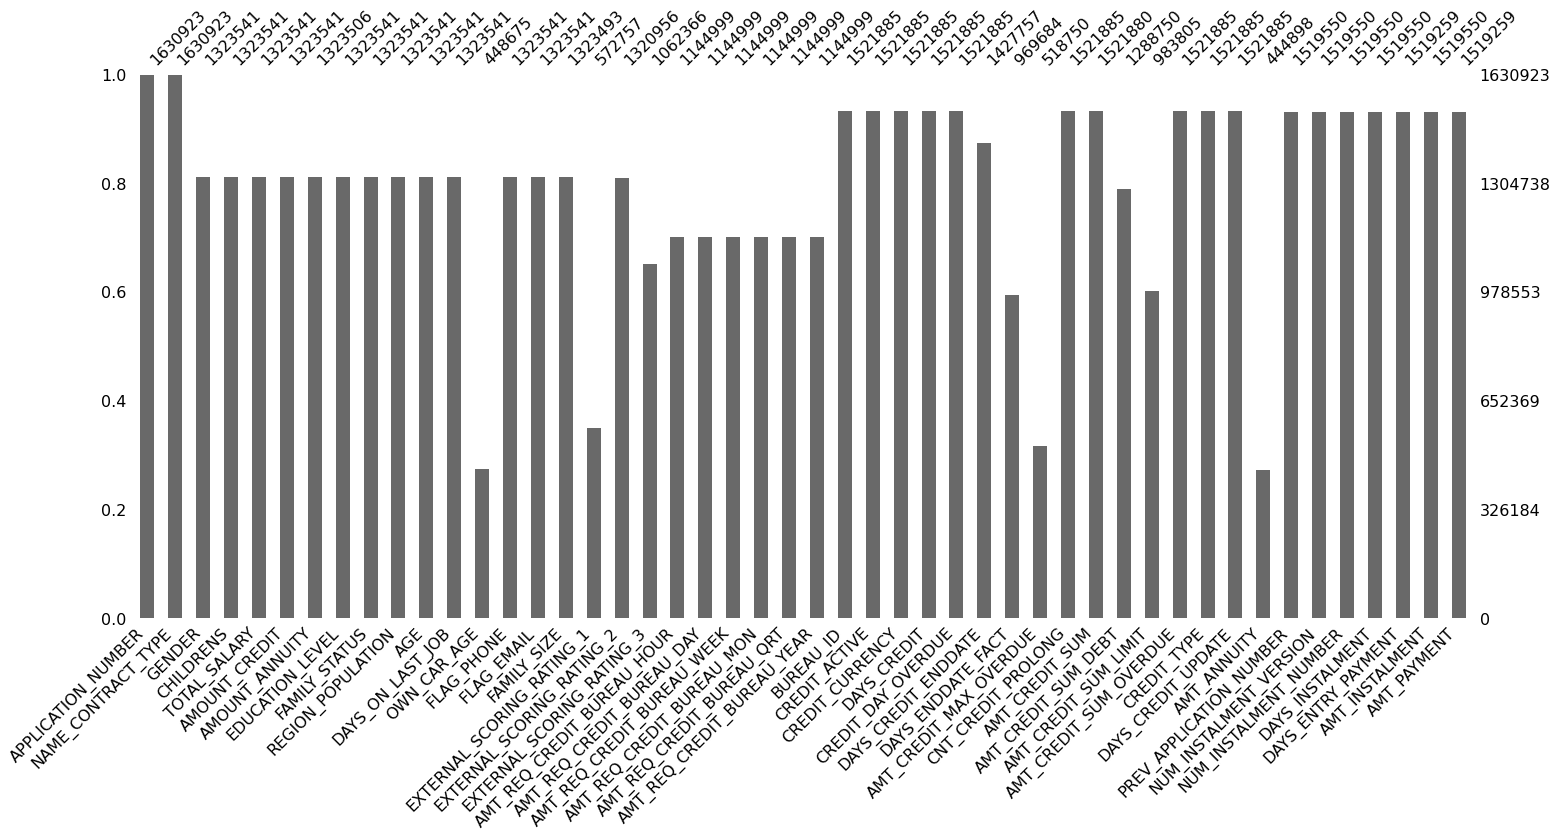

In [23]:
print("Test")
msno.bar(test);

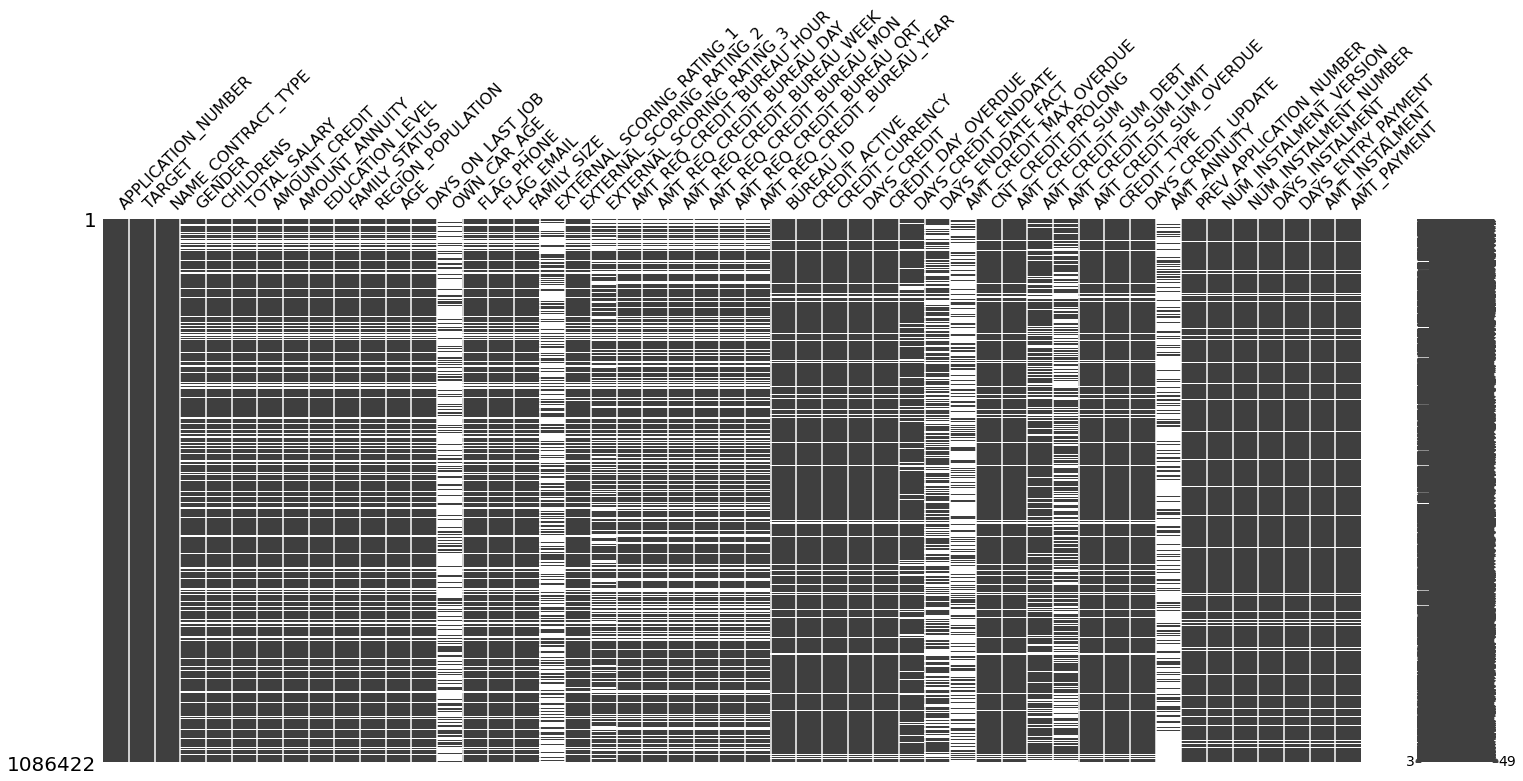

In [24]:
msno.matrix(train);

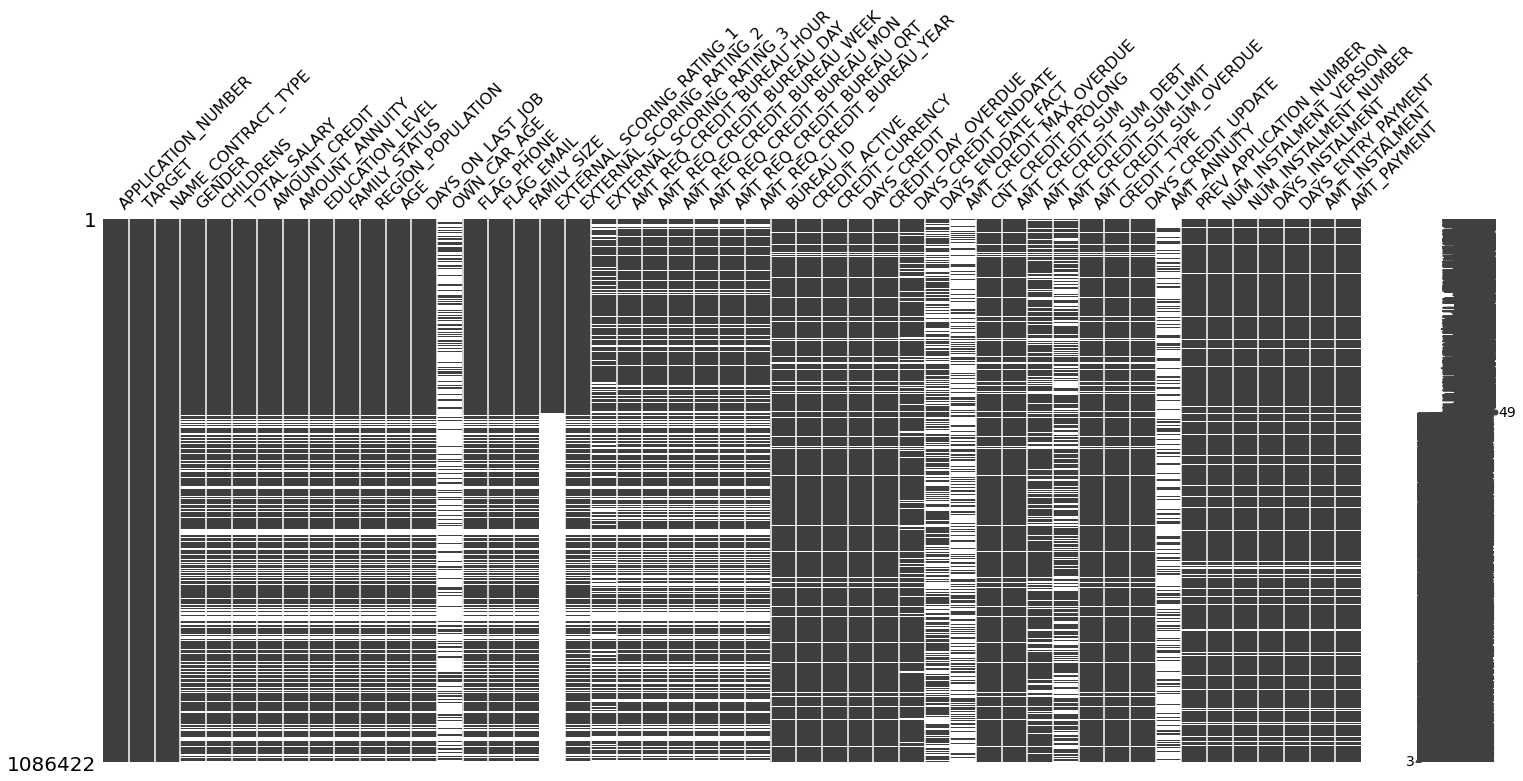

In [25]:
msno.matrix(train.sort_values(by="EXTERNAL_SCORING_RATING_1"));

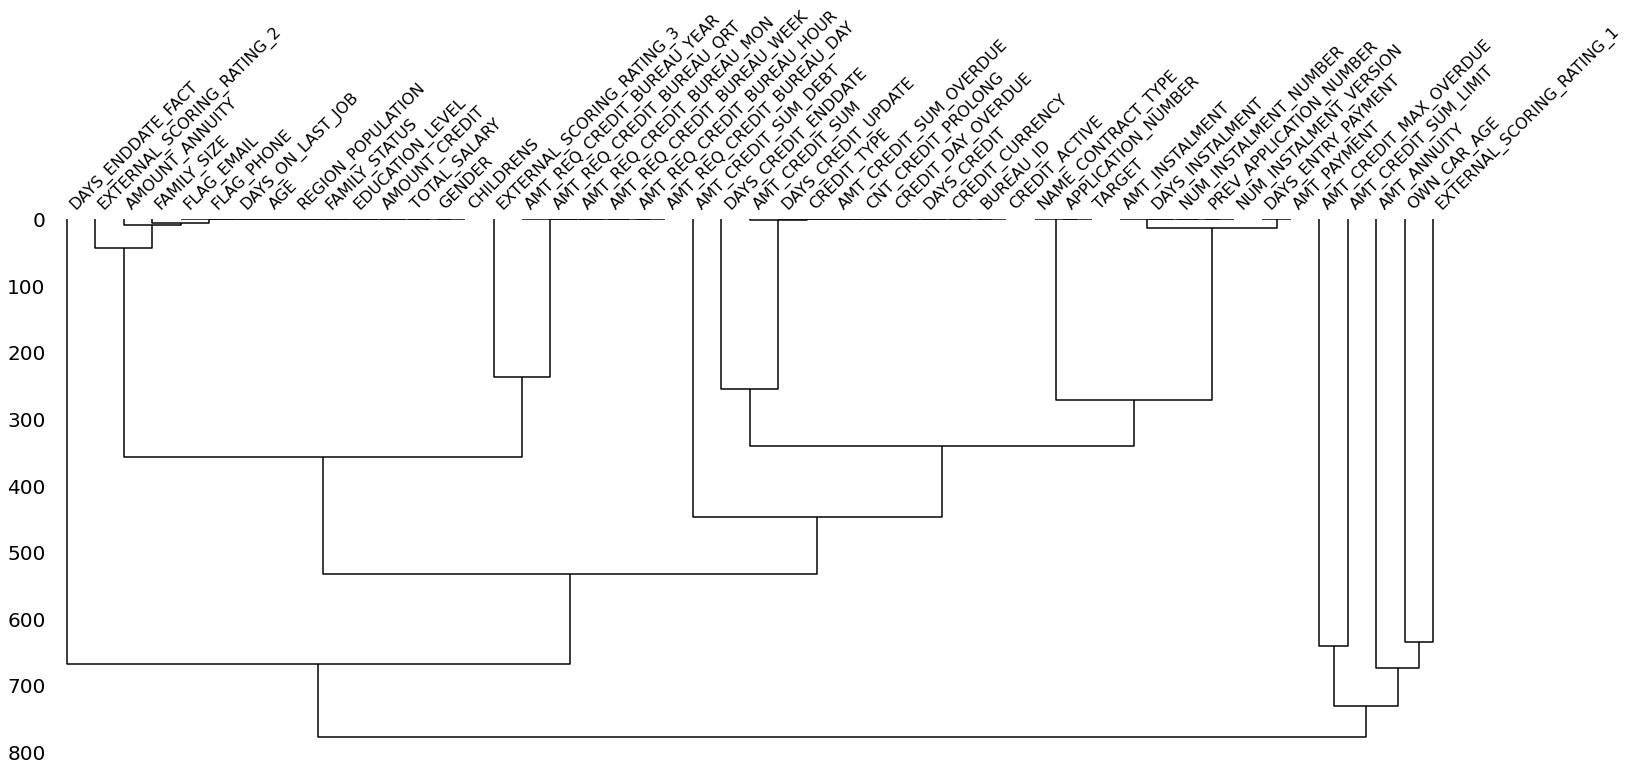

In [26]:
msno.dendrogram(train);

In [27]:
print("Features with a small amount of unique values:\n")
for feature in train.drop(columns="TARGET").columns:
    if train[feature].nunique(dropna=False) < 50 and feature[-5:] != "COUNT":
        print(f"{feature:>30}: train - test = ({train[feature].nunique(dropna=False)} - {test[feature].nunique(dropna=False)})")

Features with a small amount of unique values:

            NAME_CONTRACT_TYPE: train - test = (2 - 2)
                        GENDER: train - test = (4 - 4)
                     CHILDRENS: train - test = (14 - 11)
               EDUCATION_LEVEL: train - test = (6 - 6)
                 FAMILY_STATUS: train - test = (7 - 7)
                    FLAG_PHONE: train - test = (3 - 3)
                    FLAG_EMAIL: train - test = (3 - 3)
                   FAMILY_SIZE: train - test = (16 - 12)
    AMT_REQ_CREDIT_BUREAU_HOUR: train - test = (5 - 6)
     AMT_REQ_CREDIT_BUREAU_DAY: train - test = (9 - 8)
    AMT_REQ_CREDIT_BUREAU_WEEK: train - test = (9 - 10)
     AMT_REQ_CREDIT_BUREAU_MON: train - test = (22 - 23)
     AMT_REQ_CREDIT_BUREAU_QRT: train - test = (10 - 12)
    AMT_REQ_CREDIT_BUREAU_YEAR: train - test = (22 - 22)
                 CREDIT_ACTIVE: train - test = (5 - 5)
               CREDIT_CURRENCY: train - test = (5 - 5)
            CNT_CREDIT_PROLONG: train - test = (8 - 8)
      

In [28]:
def get_ext_scor_rating_models(data, CATEGORY_FEATURES):
    
    EXTERNAL_FEATURES = ["EXTERNAL_SCORING_RATING_1",
                         "EXTERNAL_SCORING_RATING_2",
                         "EXTERNAL_SCORING_RATING_3"]
    
    PARAMS = {"boosting_type": "gbdt",
              "num_leaves": 40,
              "max_depth": 10,
              "learning_rate": 0.01,
              "n_estimators": 30000, 
              "reg_alpha": 0.4,
              "reg_lambda": 0.4,
              "n_jobs": -1,
              "seed": 27}
    
    
    def split_by_column(df, feature):
        
        df = df[~df[feature].isnull()]
        
        drop_list = EXTERNAL_FEATURES + ["APPLICATION_NUMBER", "TARGET"]
        
        x_train, x_valid, y_train, y_valid = train_test_split(df.drop(columns=drop_list), 
                                                              df[feature], 
                                                              test_size=0.2,
                                                              random_state=27)
        
        return x_train, x_valid, y_train, y_valid
    
    
    def r2(y_true, y_pred):
        return 'R2_score', r2_score(y_true, y_pred), True
    
    
    models = {}
    
    data = data.drop(columns=CATEGORY_FEATURES)
    
    for features in EXTERNAL_FEATURES:
        
        model = lgb.LGBMRegressor(**PARAMS)

        x_train, x_valid, y_train, y_valid = split_by_column(data, features)

        model.fit(x_train, y_train,
                  eval_set=[(x_valid, y_valid)],
                  eval_metric=r2,
                  verbose=1000,
                  early_stopping_rounds=50)
        
        models[features] = model

        print(f"\nTraining model for {features} completed\n{'*' * 60}")

    return models

In [29]:
fill_external_with_models = True

CATEGORY_FEATURES = ["GENDER",
                     "EDUCATION_LEVEL",
                     "FAMILY_STATUS",
                     "FLAG_PHONE",
                     "FLAG_EMAIL",
                     "NAME_CONTRACT_TYPE",
                     "CREDIT_TYPE",
                     "CREDIT_ACTIVE",
                     "CREDIT_CURRENCY",
                     "CREDIT_TYPE"
                    ]

if fill_external_with_models:

    external_scoring_models = get_ext_scor_rating_models(train, CATEGORY_FEATURES)

    ext_list = ["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]
    for scor in ext_list:

        train.loc[train[scor].isnull(), [scor]] = external_scoring_models[scor]\
                                                    .predict(train.loc[train[scor].isnull()]
                                                             .drop(columns=CATEGORY_FEATURES + \
                                                                   ["APPLICATION_NUMBER", "TARGET"] + \
                                                                   ext_list))
        
        
    for name, model in external_scoring_models.items():
        model.booster_.save_model(f"models/base_lgb_external_scoring_{name[-1]}.mdl")

Training until validation scores don't improve for 50 rounds
[1000]	valid_0's l2: 0.0200684	valid_0's R2_score: 0.545791
[2000]	valid_0's l2: 0.017278	valid_0's R2_score: 0.608946
[3000]	valid_0's l2: 0.0152291	valid_0's R2_score: 0.65532
[4000]	valid_0's l2: 0.0136361	valid_0's R2_score: 0.691374
[5000]	valid_0's l2: 0.0123692	valid_0's R2_score: 0.720048
[6000]	valid_0's l2: 0.0112803	valid_0's R2_score: 0.744692
[7000]	valid_0's l2: 0.0103996	valid_0's R2_score: 0.764626
[8000]	valid_0's l2: 0.00966696	valid_0's R2_score: 0.781207
[9000]	valid_0's l2: 0.00901121	valid_0's R2_score: 0.796049
[10000]	valid_0's l2: 0.00843708	valid_0's R2_score: 0.809043
[11000]	valid_0's l2: 0.00795812	valid_0's R2_score: 0.819883
[12000]	valid_0's l2: 0.00754607	valid_0's R2_score: 0.829209
[13000]	valid_0's l2: 0.00720955	valid_0's R2_score: 0.836826
[14000]	valid_0's l2: 0.00688498	valid_0's R2_score: 0.844172
[15000]	valid_0's l2: 0.00661485	valid_0's R2_score: 0.850286
[16000]	valid_0's l2: 0.006

# Генерация новых признаков

In [30]:
def prepare_dfs(df):
    
    CATEGORY_FEATURES = ["GENDER", 
                         "EDUCATION_LEVEL", 
                         "FAMILY_STATUS", 
                         "FLAG_PHONE", 
                         "FLAG_EMAIL",
                         "NAME_CONTRACT_TYPE",
                         "CREDIT_TYPE",
                         "CREDIT_ACTIVE",
                         "CREDIT_CURRENCY",
                         "CREDIT_TYPE"
                        ]
    
    df["GENDER"] = df["GENDER"].replace("XNA", np.nan)
    df["FAMILY_STATUS"] = df["FAMILY_STATUS"].replace("Unknown", np.nan)
    df["DAYS_ON_LAST_JOB"] = df["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    
#     df["BUREAU_FLAG"] = np.where(df["BUREAU_ID_COUNT"].isnull(), 0, 1)
#     CATEGORY_FEATURES += ["BUREAU_FLAG"]
    
#     columns_bki = [clmn + "_COUNT" for clmn in bki.columns if clmn != "APPLICATION_NUMBER"]
#     df[columns_bki] = df[columns_bki].fillna(0)
#     df = df.drop(columns=["BUREAU_ID_COUNT"])
       
#     df["PREV_APPLICATION_NUMBER_FLAG"] = np.where(df["PREV_APPLICATION_NUMBER_MEAN"].isnull(), 1, 0)
#     CATEGORY_FEATURES += ["PREV_APPLICATION_NUMBER_FLAG"]
    
#     columns_payments = [clmn + "_MEAN" for clmn in payments.columns if clmn != "APPLICATION_NUMBER"]
#     df[columns_payments] = df[columns_payments].fillna(0)
#     df = df.drop(columns=["PREV_APPLICATION_NUMBER_MEAN"])
    
#     df["NFLAG_INSURED_ON_APPROVAL_MEDIAN_HISTORY"] = df["NFLAG_INSURED_ON_APPROVAL_MEDIAN_HISTORY"].fillna(0)
#     columns_history = [clmn + "_MEDIAN_HISTORY" for clmn in history.columns 
#                        if clmn != "APPLICATION_NUMBER" and clmn + "_MEDIAN_HISTORY" in df.columns]
#     df[columns_history] = df[columns_history].fillna(0)
    
    df["RATIO_CREDIT_TO_ANNUITY"] = df["AMOUNT_CREDIT"] / df["AMOUNT_ANNUITY"]
    df["RATIO_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / df["TOTAL_SALARY"]
    df["RATIO_CREDIT_TO_SALARY"] = df["AMOUNT_CREDIT"] / df["TOTAL_SALARY"]
        
    df["AVG_EXTERNAL_SCORING_RATING"] = df[["EXTERNAL_SCORING_RATING_1", 
                                            "EXTERNAL_SCORING_RATING_2", 
                                            "EXTERNAL_SCORING_RATING_3"]].sum(axis=1)
    
    df["WEIGHTED_EXTERNAL_SCORING_RATING_1"] = np.sum(df[["EXTERNAL_SCORING_RATING_1",
                                                          "EXTERNAL_SCORING_RATING_2",
                                                          "EXTERNAL_SCORING_RATING_3"]] * \
                                                      [1, 2, 1.8], axis=1)
    
    df["WEIGHTED_EXTERNAL_SCORING_RATING_2"] = np.sum(df[["EXTERNAL_SCORING_RATING_1",
                                                          "EXTERNAL_SCORING_RATING_2",
                                                          "EXTERNAL_SCORING_RATING_3"]] * \
                                                      [1, 3, 2], axis=1)
    
    df["WEIGHTED_MISSING_EXTERNAL_SCORING_RATING"] = np.sum(df[["EXTERNAL_SCORING_RATING_1",
                                                                "EXTERNAL_SCORING_RATING_2",
                                                                "EXTERNAL_SCORING_RATING_3"]] * \
                                                            [0.3579, 0.8098, 0.6501], axis=1)
    
    df["PRD_EXTERNAL_SCORING_RATING"] = df[["EXTERNAL_SCORING_RATING_1", 
                                            "EXTERNAL_SCORING_RATING_2", 
                                            "EXTERNAL_SCORING_RATING_3"]].product(axis=1)
    
    df["INCOME_PER_PERSON"] = df["TOTAL_SALARY"] / df["FAMILY_SIZE"]
    
    df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
    df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
    df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
    df["RATIO_SALARY_TO_EXPERIENCE"] = df["TOTAL_SALARY"] / df["DAYS_ON_LAST_JOB"]
    df["RATIO_CREDIT_TO_EXPERIENCE"] = df["AMOUNT_CREDIT"] / df["DAYS_ON_LAST_JOB"]
    df["RATIO_ANNUITY_TO_EXPERIENCE"] = df["AMOUNT_ANNUITY"] / df["DAYS_ON_LAST_JOB"]
    
    df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / df["DAYS_ON_LAST_JOB"]
    df["RATIO_SALARY_TO_REGION_POPULATION"] = df["TOTAL_SALARY"] * df["REGION_POPULATION"]
    df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
    df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
    
    df["EXPECTED_TOTAL_LOSS_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_CREDIT"]
    df["EXPECTED_TOTAL_LOSS_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_CREDIT"]
    df["EXPECTED_TOTAL_LOSS_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_CREDIT"]
    df["EXPECTED_MONTHLY_LOSS_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_ANNUITY"]
    df["EXPECTED_MONTHLY_LOSS_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_ANNUITY"]
    df["EXPECTED_MONTHLY_LOSS_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_ANNUITY"]
                                                            
    df[CATEGORY_FEATURES] = df[CATEGORY_FEATURES].astype('category')
    df["CREDIT_TYPE"] = df["CREDIT_TYPE"].astype('category')
    
    df = df.replace(-np.inf, np.nan)
    
    return df

In [31]:
train = prepare_dfs(train)
test = prepare_dfs(test)

print(f"Train.shape = {train.shape}")
print(f"Test.shape = {test.shape}")

Train.shape = (1086422, 74)
Test.shape = (1630923, 73)


# Отбор признаков

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086422 entries, 0 to 1086421
Data columns (total 74 columns):
 #   Column                                    Non-Null Count    Dtype   
---  ------                                    --------------    -----   
 0   APPLICATION_NUMBER                        1086422 non-null  int64   
 1   TARGET                                    1086422 non-null  int64   
 2   NAME_CONTRACT_TYPE                        1086422 non-null  category
 3   GENDER                                    881726 non-null   category
 4   CHILDRENS                                 881728 non-null   float64 
 5   TOTAL_SALARY                              881728 non-null   float64 
 6   AMOUNT_CREDIT                             881728 non-null   float64 
 7   AMOUNT_ANNUITY                            881646 non-null   float64 
 8   EDUCATION_LEVEL                           881728 non-null   category
 9   FAMILY_STATUS                             881700 non-null   category

In [33]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop(columns=["TARGET"]),
                                                      train["TARGET"],
                                                      test_size=0.3,
                                                      random_state=27)

In [34]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_jobs": -1,
    "seed": 27
}

dtrain = lgb.Dataset(data=x_train, label=y_train)
dvalid = lgb.Dataset(data=x_valid, label=y_valid)

model_base = lgb.train(params=params,
                       train_set=dtrain,
                       num_boost_round=10000,
                       valid_sets=[dtrain, dvalid],
                       early_stopping_rounds=10,
                       verbose_eval=200)

model_base.save_model(f"models/base_lgb_model.mdl");

Training until validation scores don't improve for 10 rounds
[200]	training's auc: 0.928984	valid_1's auc: 0.918463
[400]	training's auc: 0.962453	valid_1's auc: 0.949845
[600]	training's auc: 0.97647	valid_1's auc: 0.963343
[800]	training's auc: 0.98503	valid_1's auc: 0.97241
[1000]	training's auc: 0.990213	valid_1's auc: 0.978653
[1200]	training's auc: 0.9935	valid_1's auc: 0.982882
[1400]	training's auc: 0.995637	valid_1's auc: 0.985788
[1600]	training's auc: 0.996856	valid_1's auc: 0.987648
[1800]	training's auc: 0.997814	valid_1's auc: 0.989148
[2000]	training's auc: 0.998455	valid_1's auc: 0.990252
[2200]	training's auc: 0.998845	valid_1's auc: 0.991038
[2400]	training's auc: 0.999188	valid_1's auc: 0.991708
[2600]	training's auc: 0.999419	valid_1's auc: 0.992202
Early stopping, best iteration is:
[2624]	training's auc: 0.999435	valid_1's auc: 0.992242


In [35]:
explainer = shap.TreeExplainer(model_base)
shap_values = explainer.shap_values(x_valid.sample(n=30000, random_state=17), y_valid.sample(n=30000, random_state=17))

vals= np.abs(shap_values[1]).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(x_valid.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_feature_importance

,col_name,feature_importance_vals
52,WEIGHTED_EXTERNAL_SCORING_RATING_1,0.357584
51,AVG_EXTERNAL_SCORING_RATING,0.291591
48,RATIO_CREDIT_TO_ANNUITY,0.284071
7,EDUCATION_LEVEL,0.240568
43,NUM_INSTALMENT_NUMBER,0.180124
...,...,...
20,AMT_REQ_CREDIT_BUREAU_DAY,0.002100
29,CREDIT_DAY_OVERDUE,0.001173
37,AMT_CREDIT_SUM_OVERDUE,0.001075
26,CREDIT_ACTIVE,0.000859


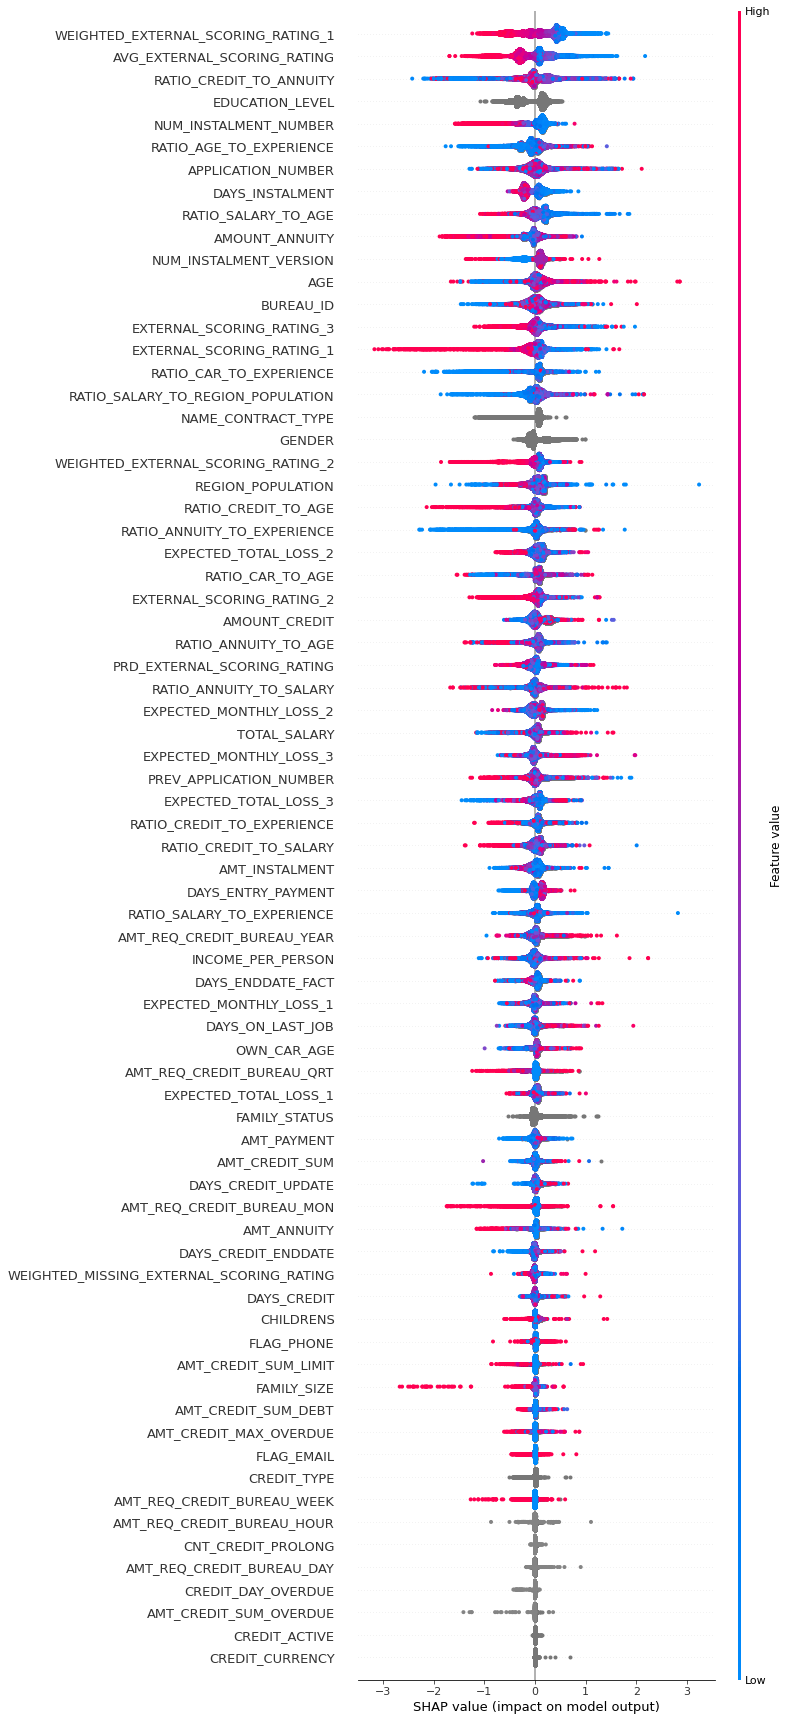

In [36]:
shap.summary_plot(shap_values[1], x_valid.sample(n=30000, random_state=17), max_display=100)

In [37]:
n_important_features = 66
important_features = shap_feature_importance["col_name"][:n_important_features].values

In [38]:
def lightgbm_cross_validation(params, X, y, cv, groups):

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(x_train, 
                  y_train,
                  eval_set=[(x_valid, y_valid)],
                  eval_metric="auc", 
                  verbose=0, 
                  early_stopping_rounds=20)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds


def catboost_cross_validation(params, X, y, cv, groups):

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    categorical = X.select_dtypes(include=['category']).columns
    X[categorical] = X[categorical].astype(str, copy=False)
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)], 
            silent=True
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, groups):

    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])

    for feature in X.select_dtypes(include=['category']).columns:
        encoder = LabelEncoder()
        X[feature] = encoder.fit_transform(X[feature].astype("str", copy=False).fillna("NA"))
        encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=5000,
            early_stopping_rounds=10,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=0
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
        folds_scores.append(score)
    print("=" * 30)
    print(time.ctime())
    return estimators, encoders, oof_preds

In [39]:
lgb_params = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 54,
    'max_depth': 10,
    'reg_alpha': 0.4,
    'reg_lambda': 0.4,
    'random_state': 327,
    'silent': -1,
    'verbose': -1
}

cb_params = {
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 0,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 8,
    "random_seed": 227
}

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.2",
    "max_depth": 7,
    "gamma": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 20,
    "tree_method": "approx",
    "alpha": 0.02,
    "lambda": 0.5,
    "nthread": -1,
    "random_seed": 127
}

In [40]:
estimators_lgb, oof_preds_lgb = lightgbm_cross_validation(params=lgb_params,
                                                          X=train[important_features], 
                                                          y=train["TARGET"], 
                                                          cv=GroupKFold(n_splits=6),
                                                          groups=train["APPLICATION_NUMBER"])

Tue Dec 29 03:18:14 2020, Cross-Validation, 1086422 rows, 66 cols
Fold 1, Valid score = 0.6971
Fold 2, Valid score = 0.70787
Fold 3, Valid score = 0.69514
Fold 4, Valid score = 0.72518
Fold 5, Valid score = 0.70099
Fold 6, Valid score = 0.69365
Tue Dec 29 03:19:57 2020


In [41]:
estimators_cb, oof_preds_cb = catboost_cross_validation(params=cb_params,
                                                        X=train[important_features],
                                                        y=train["TARGET"],
                                                        cv=GroupKFold(n_splits=6),
                                                        groups=train["APPLICATION_NUMBER"])

Tue Dec 29 03:20:00 2020, Cross-Validation, 1086422 rows, 66 cols
Fold 1, Valid score = 0.70224
Fold 2, Valid score = 0.72748
Fold 3, Valid score = 0.72184
Fold 4, Valid score = 0.74335
Fold 5, Valid score = 0.71154
Fold 6, Valid score = 0.71022
Tue Dec 29 04:26:07 2020


In [42]:
estimators_xgb, encoders_xgb, oof_preds_xgb = xgboost_cross_validation(params=xgb_params,
                                                                       X=train[important_features],
                                                                       y=train["TARGET"],
                                                                       cv=GroupKFold(n_splits=6),
                                                                       groups=train["APPLICATION_NUMBER"])

Tue Dec 29 04:26:12 2020, Cross-Validation, 1086422 rows, 66 cols
Fold 1, Valid score = 0.69536
Fold 2, Valid score = 0.70388
Fold 3, Valid score = 0.70214
Fold 4, Valid score = 0.72784
Fold 5, Valid score = 0.70659
Fold 6, Valid score = 0.70221
Tue Dec 29 04:38:48 2020


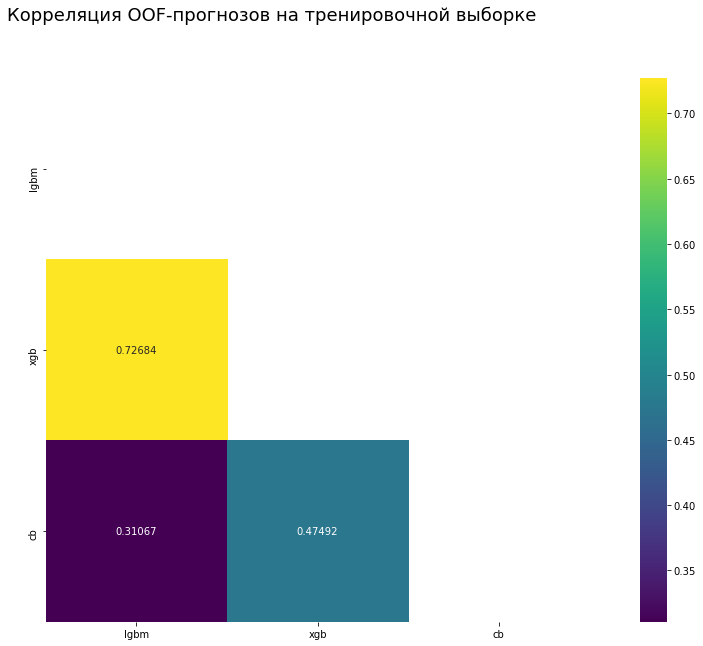

In [43]:
scores_train = pd.DataFrame({
    "lgbm": oof_preds_lgb,
    "xgb": oof_preds_xgb,
    "cb" :oof_preds_cb,
})

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".5g", square=True, cmap="viridis", ax=axes)
fig.suptitle("Корреляция OOF-прогнозов на тренировочной выборке", fontsize=18);

In [44]:
def catboost_dataset(df):
    categorical = df.select_dtypes(include=['category']).columns
    df[categorical] = df[categorical].astype(str, copy=False)
    return df


def xgboost_dataset(df, encoders=None):

    for (feature, encoder) in encoders.items():
        encoder_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
        df[feature] = df[feature].astype("str", copy=False).fillna("NA")
        df.loc[~df[feature].isin(encoder_dict.values()), feature] = list(encoder_dict.keys())[0]
        
        df[feature] = encoder.transform(df[feature])
    return xgb.DMatrix(df)

In [45]:
lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(train[important_features])[:, 1] 
              for n, estimator in enumerate(estimators_lgb)}

cb_scores = {f"cb_{n}-estimator": estimator.predict_proba(catboost_dataset(train[important_features]))[:, 1] 
             for n, estimator in enumerate(estimators_cb)}

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(xgboost_dataset(train[important_features], encoders_xgb)) 
              for n, estimator in enumerate(estimators_xgb)}

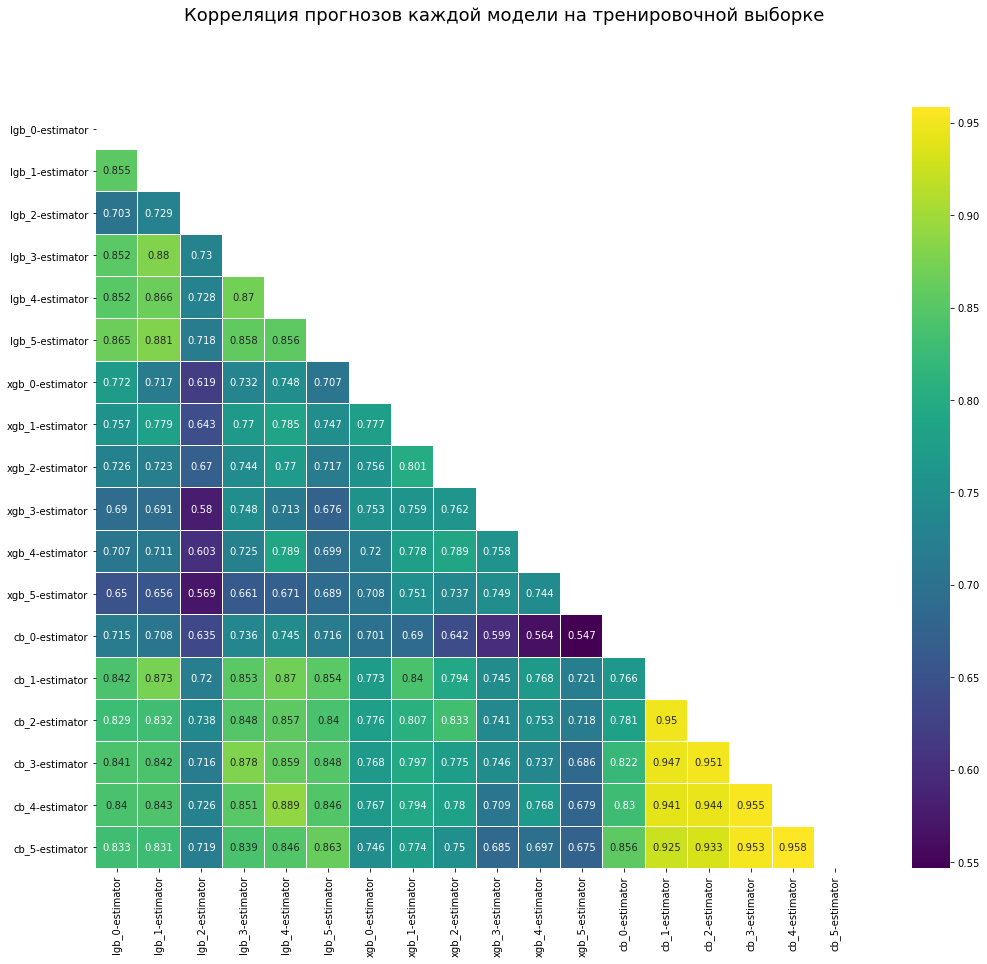

In [46]:
concat_scores = {}
concat_scores.update(lgb_scores)
concat_scores.update(xgb_scores)
concat_scores.update(cb_scores)

scores_estimators = pd.DataFrame(concat_scores)

corr = scores_estimators.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(20, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3g", square=True, cmap="viridis", ax=axes, linewidths=0.05)
fig.suptitle("Корреляция прогнозов каждой модели на тренировочной выборке", fontsize=18);

In [47]:
lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(test[important_features])[:, 1] 
              for n, estimator in enumerate(estimators_lgb)}

cb_scores = {f"cb_{n}-estimator": estimator.predict_proba(catboost_dataset(test[important_features]))[:, 1] 
             for n, estimator in enumerate(estimators_cb)}

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(xgboost_dataset(test[important_features], encoders_xgb)) 
              for n, estimator in enumerate(estimators_xgb)}

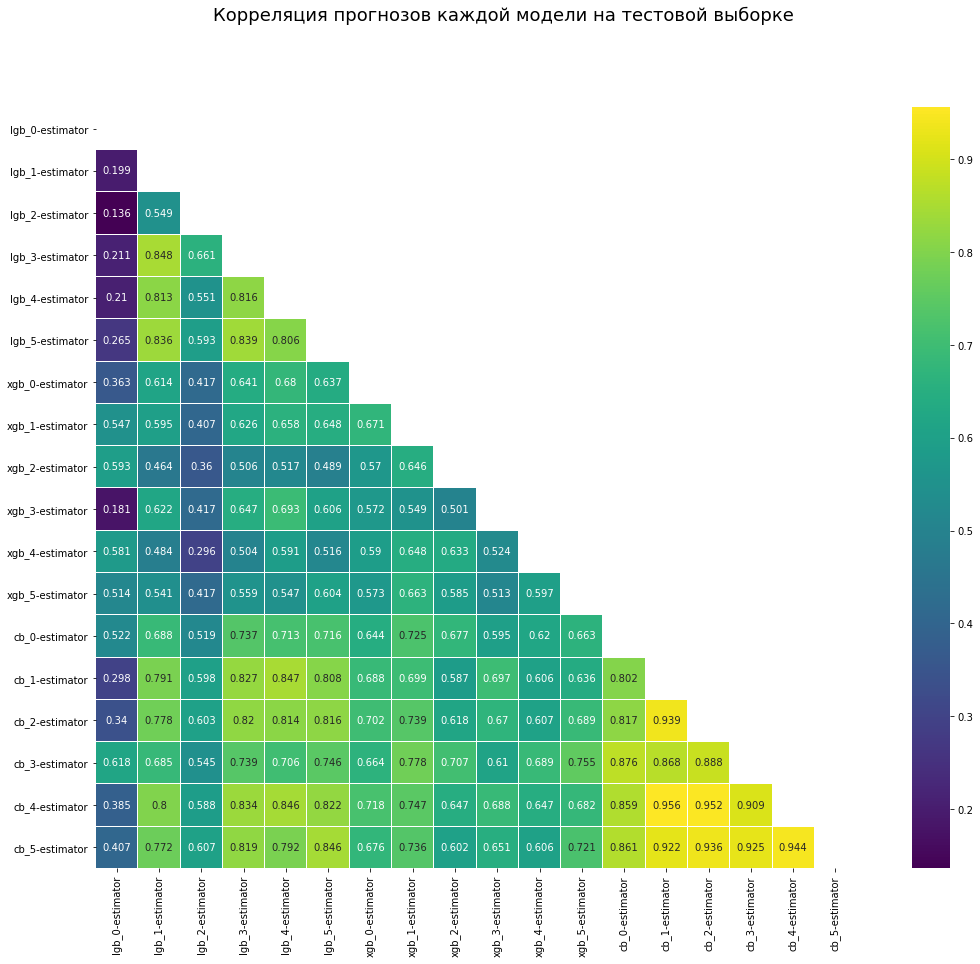

In [48]:
concat_scores = {}
concat_scores.update(lgb_scores)
concat_scores.update(xgb_scores)
concat_scores.update(cb_scores)

scores_estimators = pd.DataFrame(concat_scores)

corr = scores_estimators.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(20, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3g", square=True, cmap="viridis", ax=axes, linewidths=0.05)
fig.suptitle("Корреляция прогнозов каждой модели на тестовой выборке", fontsize=18);

In [49]:
preds = gmean(scores_estimators[[
    "lgb_3-estimator",
    "cb_3-estimator",
    "cb_2-estimator",
    "cb_0-estimator", 
    "cb_4-estimator", 
    "cb_5-estimator", 
    "xgb_3-estimator", 
    "xgb_1-estimator", 
]], axis=1)

In [50]:
test["TARGET"] = preds
groups_preds = test.groupby(by="APPLICATION_NUMBER").median().reset_index()[["APPLICATION_NUMBER", "TARGET"]]

In [51]:
submit = submit.drop(columns=["TARGET"])
final_submit = submit.merge(groups_preds, how="left", on="APPLICATION_NUMBER")
final_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.324528
1,123456549,0.266035
2,123428178,0.244131
3,123619984,0.142597
4,123671104,0.040376
...,...,...
165136,123487967,0.144050
165137,123536402,0.097079
165138,123718238,0.139487
165139,123631557,0.176104


In [52]:
final_submit.to_csv("predictions/final_submit.csv", index=False)